## CNN

### Assignment 4

Previously in 2_fullyconnected.ipynb and 3_regularization.ipynb, we trained fully connected networks to classify notMNIST characters.

The goal of this assignment is make the neural network convolutional.

In [8]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [9]:
pickle_file = "./notMNIST.pickle"

with open(pickle_file, "rb") as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:

convolutions need the image data formatted as a cube (width by height by #channels)
labels as float 1-hot encodings.

In [10]:
image_size = 28
num_labels = 10
num_channels = 1

import numpy as np

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:, None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [7]:
def accuracy(predictions, labels):
    return (100 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
           / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [19]:
batch_size = 16
patch_size = 5  # filter size
depth = 16 # filter nums
num_hidden = 64

graph = tf.Graph()

with graph.as_default():
    
    # Input Data
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels)
    )
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables
    layer1_weights = tf.Variable(
        tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1)
    )
    layer1_biases = tf.Variable(tf.zeros([depth]))
    
    layer2_weights = tf.Variable(
        tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1)
    )
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    
    layer3_weights = tf.Variable(
        tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1)
    )
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    layer4_weights = tf.Variable(
        tf.truncated_normal([num_hidden, num_labels], stddev=0.1)
    )
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    
    # Model
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1,2,2,1], padding="SAME")
        print("conv1", conv.shape)
        hidden = tf.nn.relu(conv + layer1_biases)
        conv = tf.nn.conv2d(hidden, layer2_weights, [1,2,2,1], padding="SAME")
        print("conv2", conv.shape)
        hidden = tf.nn.relu(conv + layer2_biases)
        shape = hidden.get_shape().as_list()
        print("shape",shape)
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases
    
    # Training Computation
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
    )
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.02).minimize(loss)
    
    # Prediction for train valid test
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

conv1 (16, 14, 14, 16)
conv2 (16, 7, 7, 16)
shape [16, 7, 7, 16]
conv1 (10000, 14, 14, 16)
conv2 (10000, 7, 7, 16)
shape [10000, 7, 7, 16]
conv1 (10000, 14, 14, 16)
conv2 (10000, 7, 7, 16)
shape [10000, 7, 7, 16]


In [20]:
num_steps = 2001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Init")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset:batch_data, tf_train_labels:batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict
        )
        if step % 50 == 0:
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Init
Minibatch loss at step 0: 3.673247
Minibatch accuracy: 18.8%
Validation accuracy: 11.1%
Minibatch loss at step 50: 1.780114
Minibatch accuracy: 37.5%
Validation accuracy: 51.5%
Minibatch loss at step 100: 1.502041
Minibatch accuracy: 62.5%
Validation accuracy: 60.1%
Minibatch loss at step 150: 0.684526
Minibatch accuracy: 81.2%
Validation accuracy: 73.3%
Minibatch loss at step 200: 0.890489
Minibatch accuracy: 87.5%
Validation accuracy: 73.0%
Minibatch loss at step 250: 1.024285
Minibatch accuracy: 62.5%
Validation accuracy: 74.9%
Minibatch loss at step 300: 0.665337
Minibatch accuracy: 81.2%
Validation accuracy: 78.0%
Minibatch loss at step 350: 0.310169
Minibatch accuracy: 93.8%
Validation accuracy: 78.5%
Minibatch loss at step 400: 1.099694
Minibatch accuracy: 62.5%
Validation accuracy: 78.5%
Minibatch loss at step 450: 0.843119
Minibatch accuracy: 75.0%
Validation accuracy: 80.0%
Minibatch loss at step 500: 1.868180
Minibatch accuracy: 56.2%
Validation accuracy: 80.9%
Minibatc

#### Problem 1

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (nn.max_pool()) of stride 2 and kernel size 2.

In [21]:
batch_size = 16
patch_size = 5  # filter size
depth = 16 # filter nums
num_hidden = 64

graph = tf.Graph()

with graph.as_default():
    
    # Input Data
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels)
    )
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables
    layer1_weights = tf.Variable(
        tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1)
    )
    layer1_biases = tf.Variable(tf.zeros([depth]))
    
    layer2_weights = tf.Variable(
        tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1)
    )
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    
    layer3_weights = tf.Variable(
        tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1)
    )
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    layer4_weights = tf.Variable(
        tf.truncated_normal([num_hidden, num_labels], stddev=0.1)
    )
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    
    # Model
    def model(data):
        # conv layer 1
        conv = tf.nn.conv2d(data, layer1_weights, [1,1,1,1], padding="SAME")
        hidden = tf.nn.relu(conv + layer1_biases)
        pool = tf.nn.max_pool(hidden,
                             ksize=[1,2,2,1],
                             strides=[1,2,2,1],
                             padding="VALID")
        # conv layer 2
        conv = tf.nn.conv2d(pool, layer2_weights, [1,1,1,1], padding="SAME")
        hidden = tf.nn.relu(conv + layer2_biases)
        pool = tf.nn.max_pool(hidden,
                             ksize=[1,2,2,1],
                             strides=[1,2,2,1],
                             padding="VALID")
        shape = pool.get_shape().as_list()
        print("shape",shape)
        reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases
    
    # Training Computation
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
    )
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.02).minimize(loss)
    
    # Prediction for train valid test
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

shape [16, 7, 7, 16]
shape [10000, 7, 7, 16]
shape [10000, 7, 7, 16]


In [22]:
num_steps = 2001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Init")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset:batch_data, tf_train_labels:batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict
        )
        if step % 50 == 0:
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Init
Minibatch loss at step 0: 3.646344
Minibatch accuracy: 12.5%
Validation accuracy: 8.0%
Minibatch loss at step 50: 1.871946
Minibatch accuracy: 31.2%
Validation accuracy: 47.0%
Minibatch loss at step 100: 1.435126
Minibatch accuracy: 62.5%
Validation accuracy: 53.6%
Minibatch loss at step 150: 0.584958
Minibatch accuracy: 81.2%
Validation accuracy: 70.2%
Minibatch loss at step 200: 0.783134
Minibatch accuracy: 87.5%
Validation accuracy: 72.4%
Minibatch loss at step 250: 1.232164
Minibatch accuracy: 68.8%
Validation accuracy: 72.0%
Minibatch loss at step 300: 0.846690
Minibatch accuracy: 81.2%
Validation accuracy: 78.4%
Minibatch loss at step 350: 0.373365
Minibatch accuracy: 93.8%
Validation accuracy: 78.8%
Minibatch loss at step 400: 1.160614
Minibatch accuracy: 62.5%
Validation accuracy: 77.2%
Minibatch loss at step 450: 0.898671
Minibatch accuracy: 75.0%
Validation accuracy: 79.9%
Minibatch loss at step 500: 1.738029
Minibatch accuracy: 62.5%
Validation accuracy: 80.3%
Minibatch

#### Problem 2

Try to get the best performance you can using a convolutional net. Look for example at the classic LeNet5 architecture, adding Dropout, and/or adding learning rate decay.

In [94]:
batch_size = 16
patch_size = 5  # filter size
depth = 16 # filter nums
num_hidden = 64

initial_learning_rate = 0.05
learning_rate_decay_factor = 0.95
decay_steps = 50

graph = tf.Graph()

with graph.as_default():
    
    # Input Data
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels)
    )
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    # 增加dropout
    tf_keep_pro = tf.placeholder(tf.float32)
    
    # Variables
    layer1_weights = tf.Variable(
        tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1)
    )
    layer1_biases = tf.Variable(tf.zeros([depth]))
    
    layer2_weights = tf.Variable(
        tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1)
    )
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    
    
    layer3_weights = tf.Variable(
        tf.truncated_normal([(image_size // 4) * (image_size // 4) * depth, num_hidden], stddev=0.1)
    )
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    # Full Connected
    layer4_weights = tf.Variable(
        tf.truncated_normal([num_hidden, num_classes], stddev=0.1)
    )
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_classes]))
    
    
    
    # Model
    def model(data, keep_pro):
        # conv layer 1
        conv = tf.nn.conv2d(data, layer1_weights, [1,1,1,1], padding="SAME")
        hidden = tf.nn.relu(conv + layer1_biases)
        pool = tf.nn.max_pool(hidden,
                             ksize=[1,2,2,1],
                             strides=[1,2,2,1],
                             padding="VALID")
        # conv layer 2
        conv = tf.nn.conv2d(pool, layer2_weights, [1,1,1,1], padding="SAME")
        hidden = tf.nn.relu(conv + layer2_biases)
        pool = tf.nn.max_pool(hidden,
                             ksize=[1,2,2,1],
                             strides=[1,2,2,1],
                             padding="VALID")
        
        # Full Connected
        shape = pool.get_shape().as_list()
        print("shape",shape)
        reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        # 增加Dropout
        hidden_drop = tf.nn.dropout(hidden, keep_pro)
    
        return tf.matmul(hidden_drop, layer4_weights) + layer4_biases
    
    # Training Computation
    logits = model(tf_train_dataset, tf_keep_pro)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
    )
    
    # Optimizer
    # 增加learning_rate
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(initial_learning_rate,
                                               global_step,
                                               decay_steps,
                                               learning_rate_decay_factor,
                                               staircase=True,
                                               )
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    # Prediction for train valid test
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset, tf_keep_pro))
    test_prediction = tf.nn.softmax(model(tf_test_dataset, tf_keep_pro))

shape [16, 7, 7, 16]
shape [10000, 7, 7, 16]
shape [10000, 7, 7, 16]


In [95]:
num_steps = 3001

loss_list = []

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Init")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset:batch_data, tf_train_labels:batch_labels, tf_keep_pro:0.5}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict
        )
        if step % 50 == 0:
            loss_list.append(l)
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(
            {tf_train_dataset:batch_data, tf_train_labels:batch_labels, tf_keep_pro:1}), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(
    {tf_train_dataset:batch_data, tf_train_labels:batch_labels, tf_keep_pro:1}), test_labels))

Init
Minibatch loss at step 0: 4.076749
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 50: 2.301419
Minibatch accuracy: 6.2%
Validation accuracy: 17.6%
Minibatch loss at step 100: 2.298007
Minibatch accuracy: 31.2%
Validation accuracy: 20.1%
Minibatch loss at step 150: 1.481355
Minibatch accuracy: 43.8%
Validation accuracy: 52.2%
Minibatch loss at step 200: 1.480799
Minibatch accuracy: 50.0%
Validation accuracy: 68.1%
Minibatch loss at step 250: 1.303537
Minibatch accuracy: 62.5%
Validation accuracy: 72.4%
Minibatch loss at step 300: 1.181466
Minibatch accuracy: 50.0%
Validation accuracy: 74.1%
Minibatch loss at step 350: 0.864792
Minibatch accuracy: 68.8%
Validation accuracy: 76.1%
Minibatch loss at step 400: 1.259225
Minibatch accuracy: 68.8%
Validation accuracy: 77.9%
Minibatch loss at step 450: 0.944868
Minibatch accuracy: 62.5%
Validation accuracy: 77.1%
Minibatch loss at step 500: 1.899414
Minibatch accuracy: 56.2%
Validation accuracy: 78.9%
Minibatch 

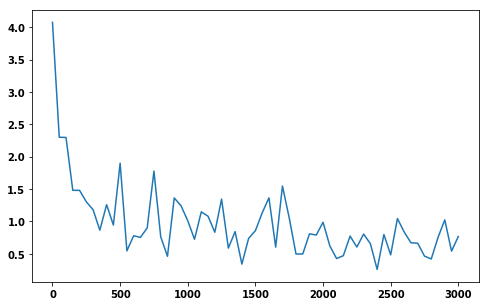

In [96]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,5))
plt.plot(range(0, 3050, 50), loss_list)